In [1]:
from warnings import warn

In [2]:
# Standard library imports
import os
from datetime import datetime

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import dill

# Local application imports
from smile.population import Population, PopulationList
from smile.sampling import *
from smile import helper
from smile.global_params import *

In [3]:
#from smile/sampling.py

# Standard library imports
from collections import UserList
from abc import ABC, abstractmethod #abstract base class
from functools import partial #for binding variables to functions

# Third party imports
import numpy as np
import numpy.ma as ma

# Local application imports
from smile.population import Population, PopulationList
from smile import helper
from smile.helper import warn
from smile.global_params import get_MIN, NDAYS, FIRSTVISIT, LASTVISIT
from smile.global_params import _UNREACHED_SMILE, _UNREACHED_MAGNITUDE, _LIMITREACHED, _ALREADYREACHED

In [4]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)
pickle_dir = 'D:\saved_populations_8_3'

In [5]:
# Pickling functions
def dump_to_file(obj, filename, filesuffix='.pik', 
                 dirname=None, create_newdir=False, avoid_overwrite=True):
    #build path
    if dirname is not None: 
        if not os.path.isdir(dirname):
            if create_newdir:
                os.makedirs(dirname)
                print(f"Directory {dirname} was created")
            else:
                raise OSError(f"Directory {dirname} doesn't exist and needs to be created")
        filename = os.path.join(dirname, filename+filesuffix)
    else:
        filename = filename+filesuffix
    #check if will overwrite
    if os.path.isfile(filename) and avoid_overwrite:
        raise OSError(f"File {filename} already exists and would be overwritten")
    else:
        with open(filename, 'wb') as f:
            dill.dump(obj, f, protocol=4)
def load_from_file(filename):
    with open(filename, 'rb') as f:
        return dill.load(f)

In [6]:
# Definitions
#populations
def get_poster_populations(slope_option, error_option, npersons=100, npops=100):
    '''
    returns a PopulationList similar to the one described in the poster
    slope_option is 1, 2, or 3
    error_option is 30/100 or 50/100
    '''
    
    # Define and set visual score function
    pop = Population(npersons, f'poster with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 0.2
    gen_v0 = lambda shape: np.random.randint(14, 18+1, shape)
    pop.set_parameter_generator('r', gen_r, 'population')
    pop.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a,s0: np.maximum(a*v+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    gen_s0 = lambda shape: np.random.normal(6, 2, shape)
    pop.set_parameter_generator('a', gen_a, 'population')
    pop.set_parameter_generator('s0', gen_s0, 'person')

    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops
def get_worddoc_populations(slope_option, error_option, npersons=100, npops=100):
    
    # Define and set visual score function
    pop = Population(npersons, title=f'realistic with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: helper.beta(shape, 0, 2, 0.2, 1.4) #median at 0.4
    gen_v0 = lambda shape: helper.truncatednormal_general(14, 16, 18, 1, shape)
    pop.set_parameter_generator('r', gen_r, 'person')
    pop.set_parameter_generator('v0', gen_v0, 'person')
    
    #Define and set symptom score functions
    gen_symptomscores = lambda v,a: a*(v-VMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    pop.set_parameter_generator('a', gen_a, 'population')
    
    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops
#simulations
def get_traditional_methodology():
    methodology = Methodology('traditonal')

    first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21

    methodology.add_sampler(TraditionalSampler(day=0, delay=first_delay_func))
    methodology.add_sampler(TraditionalSampler(day=('sample', -1), delay=14))
    methodology.add_sampler(TraditionalSampler(day=('sample', -1), delay=14))

    return methodology
def get_realistic_methodology():
    methodology = Methodology('realistic')

    #limit is irrelevant because max(day+delay) < NDAYS
    #if_reached is irrelevant because first sampling method
    first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21
    sampler1 = TraditionalSampler(day=0, delay=first_delay_func)
    methodology.add_sampler(sampler1)

    #if_reached is irrelevant because index is previous sample
    other_delay_func = lambda shape: helper.beta(shape, 0, 14, 4, 3.8).astype('int') #90% at 7
    sampler2 = SmileSampler(index=('sample', -1), ratio=0.5, scorename='symptom',
                            delay=other_delay_func, triggered_by_equal=True, min_triggered=1, 
                            #limit=((-1, lambda prev_day: prev_day+28), 'clip'), if_reached='NaN')
                            limit=(2*_LIMITREACHED, 'NaN'), if_reached='NaN')
    methodology.add_sampler(sampler2)

    #same delay as previous
    sampler3 = MagnitudeSampler(value=2, scorename='symptom',
                                delay=other_delay_func, triggered_by_equal=True,
                                #limit=(LASTVISIT, 'clip'), if_reached='NaN')
                                limit=(2*_LIMITREACHED, 'NaN'), if_reached='NaN')
    methodology.add_sampler(sampler3)

    return methodology

In [7]:
#parameters
npersons=1000
npops=1000
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

In [8]:
np.random.seed(seed)

npops=1
index = 0

if index is not None: 
    suffix='_'+str(index)
    verbose = False
else: 
    suffix=''
    verbose = True

#preallocate arrays
poplists_shape = (len(slope_options), len(error_options))
poster_poplists = np.empty(poplists_shape, dtype=object)
worddoc_poplists = np.empty(poplists_shape, dtype=object)

In [9]:
'''#create and generate
for i, j in np.ndindex(poplists_shape):
    if verbose: print(i, j)
    options = (slope_options[i], error_options[j])
    poster_poplists[i, j] = get_poster_populations(*options, npersons, npops)
    worddoc_poplists[i, j] = get_worddoc_populations(*options, npersons, npops)
    poster_poplists[i, j].generate()
    worddoc_poplists[i, j].generate()

#pickle
dump_to_file(poster_poplists, 'poster_poplists'+suffix, dirname=pickle_dir, create_newdir=True)
dump_to_file(worddoc_poplists, 'worddoc_poplists'+suffix, dirname=pickle_dir)
if verbose: print("Done generation.")


# Filtering

#define
filter_kwargs = {'filter_type':'ratio_early', 'copy':True,
                 'index_day':0, 'recovered_ratio':0.4, 'scorename':'symptom'}

#preallocate arrays
poster_filtered_poplists = np.empty_like(poster_poplists)
worddoc_filtered_poplists = np.empty_like(worddoc_poplists)

#filter
for i, j in np.ndindex(poplists_shape):
    if verbose: print(i, j)
    poster_filtered_poplists[i, j] = poster_poplists[i, j].filter(**filter_kwargs)
    worddoc_filtered_poplists[i, j] = worddoc_poplists[i, j].filter(**filter_kwargs)

#pickle
dump_to_file(poster_filtered_poplists, 'poster_filtered_poplists'+suffix, dirname=pickle_dir)
dump_to_file(worddoc_filtered_poplists, 'worddoc_filtered_poplists'+suffix, dirname=pickle_dir)
if verbose: print("Done filtering.")
    
#state = np.random.get_state()
#print(state)'''
print()

In [10]:
state = ('MT19937', np.array([2962524577, 1673754294, 1403069053, 3310752670, 2150748404, 1614059452, 2497208348, 1640151344, 3468855398, 3720181135, 1891071198, 1956677444, 4019869901, 2257263567,  162440196, 2896027871,  555007269, 3132089494,  106028734, 2444731365, 2696487513, 3958701767, 2953116324, 1234582482, 3789125954, 3463075842,  294109048, 4204826201, 3617146104, 4045101201, 2755258201, 4127667857, 3696684517, 1208452850, 1208056221, 1045749637, 1596697527, 2772050092, 4288039924, 1435200570,  193151316, 2522991091, 2951580961, 3587302748, 2224023524, 4280287261, 4196025060, 2009477641, 4281943410, 1595652892, 2447706052, 3309857241, 2685832696, 4035670494, 3142604370,  916922574, 2222859523, 4197045632, 1922629509,  460303068, 3157486035, 1537336642, 4053129777,  247110365, 4144466430, 2232095284, 3939371760, 2576373998, 1603351964, 1052312235, 3165573111, 3248186934,  603172881, 2991203459, 1507010990,  658859037, 3998804971, 4283297135, 3929143711, 3332227784,  159059983, 3272388240, 2394159390, 1047738837, 3372245351, 2869973426, 3647313694,  785953559, 1193884913, 2560162864,  125121977, 3933898792, 3147402066, 1083935805, 3183949652, 3075823144,  424169932, 1458051273, 2353087904, 2493346307, 1610737908, 1023045591, 3691117245,  910595644, 2620136404, 1896848137, 1778754715, 1360761329, 3678669641, 3051695931, 2132869126, 3145689170, 2905933491, 1042741354,  401846631,  325388124, 2543504141, 1328618882, 4172701060, 1988443744, 3196167787,  247109501, 2501678380, 3633333619, 2955112146,  159847684, 3751301928, 3905104983, 4251988045, 1498133574, 3193683786,   20590818, 2598381305,  172533427,   91922338, 1130296217,  546489405, 4054577000, 3714128153,  458397046, 1763222388, 3582846067, 4218733163, 2751428247, 3117554187, 2487007324,   50137688, 1311023416, 3703944428, 1915565849, 3021674350, 3950901711, 3231144900,  856493185, 1138515845, 3992657139,  823286758, 4241908457, 2666948650, 3825104051, 2556924563, 2260358832, 3290204568, 2840732707,  798747408,  437653215,  224237832,  727918936, 3990567187, 2582256652, 2310117940, 3752012301,  191213546, 3490914805,  616832337, 3577660776, 3928896522, 1405031918, 2489501508,  748149056, 1798669675, 1066643391,  728029821, 4100582468,  443975640, 4241552582, 3872657472, 1531154470, 2509111327, 3604404577, 3675838967, 1159415143, 1153970042, 3250109838, 3988113558, 1760587973, 1266479929, 2540146897, 2519308032,  773012932, 3247767323, 1487448203, 2522487160,  289182580, 4134348588, 4043692091, 3098759610,  602528582, 3136320525,  657224585, 3190563644, 3629928680,  474995258,  988388115, 2980371030,  304847411, 1523623158, 3599771938, 3299560547, 2144130719,  766376746, 1057584629, 1868584901, 3011282311, 3189475582, 1818760880, 3073194227, 2795354778, 1371194107,  172409568, 3859038954, 2566552990, 1750446490, 1686241969,  604518425, 1939219951, 4099853735, 3839807536,  400270144, 2464469330,  112289859,  276763250, 1634081348,  399122302, 2000116946,  216086402, 3452966769, 1588855574, 3322782230,  574544822, 2490654753,  409212381,  160265617, 3017049346, 3573444927, 1740522960, 2686049101, 1268168538, 2655713465, 3267993503, 4022240039,  804852897, 4216470745, 3417442739, 3643715596, 3767901146, 2760423213, 3289870105, 3099037359, 1602202114, 3218763688, 3248046158, 2302587493, 3433950259, 1637741184, 1897434504,  407705558, 4034163292,  819439911, 2332097103, 3858654421,  873470642, 2735453630, 3096875808, 3325797208, 3907789038, 4161038521, 2889651917, 3816972814, 4176252369, 1170576903, 1023289567, 3384682584, 2454132438, 1772809864, 3232012054,  258664869,   29361161, 3047011742, 2612168855, 4110077122, 1258093998,  485843318, 1543947621, 1579258454, 3280950267, 3181442110, 2693516283, 3027633405,  939778273,  467598849,  481820279,  833565246,  121940299, 3557298006, 1137114277, 2878542548, 3692700970, 3195167106, 2932098987, 2271709511,  124450586, 2837988573, 3343731580, 4087790421, 2149544497, 1976223870, 1029951797, 3028662352, 3996077178,  122305908, 1442086068, 1376730351,  550413091,   19576414, 1806294422, 3985692241, 2688598763, 1881570248, 2712957892, 3896091527,   29345295, 3092670640,  778027226, 3103601603, 1992976343, 3094613427,  757767149,  695296982, 4112843937, 1323920881, 4021047683, 3591571655, 3491965425,  818183058, 1291619059,  651739426, 3648804909,  828520920, 1448496566, 2371212545, 1367110566, 2168314386,  172084378, 2678052721, 3681962451, 3472692927, 2080736518, 4233370017, 1676249706, 2924068216, 1983538652, 1281805945, 2260113446,  959302891, 3374405301, 1037842103, 3705345261,  310580684,    3953313,  196266935, 1035520356, 2703547154,  726563311,  432347905, 3749926353, 1763857169, 1503918235, 3850932828, 1147999315, 3890753832, 3672023121, 2678033133,  948241286, 2504439749, 2770280188,  930828587,  358243772, 2161514302,  837717577,  857475039, 2538739232,  378183472, 2370250179, 1887909332, 3565223139, 1986615431, 1485637523,    4327776, 1976287010,  743098000, 4083083894, 3514648614, 2189986080,  698788302, 1189285076, 2204052099, 3373516581, 3073364029, 4206978005, 4236068855, 2347145695, 2774111166, 1600907130, 1916959399, 3236109786, 3963543818, 2105702810,  329575020, 4280626477, 1406677975, 3609725891,  143530962, 2718747814,  283040834, 2283013549, 1052223275, 1033473294, 2177958675, 1589816008, 2898279465, 3373298705, 1382445692,  239497181, 3156311709,  530127651, 1163969480, 1250063549, 3352918279, 3186410165, 3225879328, 4134636515, 2468392437, 2638035009, 1125790721, 3699499030,  470177812, 1652476610, 2106353707, 1868242572, 2596842009,  768563123,  731126592, 3286590604, 4022795771, 1952073786, 1092644780, 1227240983,  258223923, 2943347620, 3884112101, 2442608769, 3349363935, 2386665317, 3668459484, 1595682394, 1137419649,  713016728, 2271093243, 1177480870,  862085350, 3376267549, 1483115310, 3188758783,  438971434, 2510254426, 2744770629, 3682203590, 3413431247, 1799877235, 3935831478, 2370754455, 1914116326, 1584963998, 2943467219,  279152663, 2786891411, 1801032995, 3019475041, 1707476310, 1383584266, 2059399810, 2348896768, 2611882787, 3301254041, 2672059828,  184265119, 1995976162, 1370574739, 2454464359, 2851498681, 2835628138, 3029051602, 3719053529, 2197887792,  964027880, 3233749272, 3162825811, 1583403689,  298968295, 1804700651, 3214091402, 2484536503, 2130593391, 2996589674,  897206310,  356933663, 1223526713, 3237896562, 2149975732, 2092572945, 3404123592,  990816278, 4192578854,  639249798, 2352662600, 1373524013, 2044931199, 2148934903, 3931691687, 2331301744, 3311943788,  664370375, 2700307854, 4248311467,  805367239, 2148042870, 3179039611, 1813725381,  103693824, 2597638614,  937648497, 1723817120, 4214114431, 3802228538,  293416013, 3870415730, 1753958486, 2768811752, 3048068887, 1958767403, 1499272821, 3870475792, 3207204027, 2749643173, 1033467119, 2982247581,  881776377,   53015050, 3270058793, 2545446936, 1762121894,  392707276,  283103343, 3626883096,  567148963, 2308596262, 2158148095, 2517037061, 3953488342, 2380100455, 1122082151, 2204695252, 2645717296, 3714180060,  818424913, 3944434964, 4212845964,  590085573, 1267185197, 3834012992, 3161683923,  675704302, 1763327952, 1874499649,  775946824, 1325582977,  722539037, 3014031185,  282981467, 3531430042,  667410577, 4102525186, 3286861729, 1144479092, 3051622034,  743370302, 2541324332, 2273963046, 3345702893,  442928778, 2243918487, 4037343766,   87899595, 3646913063, 2858221825,  112127098, 3018166720, 2621981463, 3533239191, 3470380540, 3563258168,  989357537, 3057231140], dtype=np.uint32), 235, 0, 0.0)

In [11]:
poster_filtered_poplists = load_from_file(pickle_dir+"\poster_filtered_poplists_0.pik")
worddoc_filtered_poplists = load_from_file(pickle_dir+"\worddoc_filtered_poplists_0.pik")

In [12]:
np.random.set_state(state)

# Sampling

#create
methodologies = [get_traditional_methodology(), get_realistic_methodology()]

#preallocate arrays
sampled_poplists_shape = (*poplists_shape, len(methodologies))
poster_sampled_poplists = np.empty(sampled_poplists_shape, dtype=object)
worddoc_sampled_poplists = np.empty(sampled_poplists_shape, dtype=object)

In [13]:
'''#sample
for i, j in np.ndindex(poplists_shape):
    if verbose: print(i, j, 'poster', 0)
    poster_sampled_poplists[i, j, 0] = methodologies[0].sample(poster_filtered_poplists[i, j])
    if verbose: print(i, j, 'poster', 1)
    poster_sampled_poplists[i, j, 1] = methodologies[1].sample(poster_filtered_poplists[i, j])
    if verbose: print(i, j, 'poster', 0)
    worddoc_sampled_poplists[i, j, 0] = methodologies[0].sample(worddoc_filtered_poplists[i, j])
    if verbose: print(i, j, 'poster', 1)
    worddoc_sampled_poplists[i, j, 1] = methodologies[1].sample(worddoc_filtered_poplists[i, j])


#pickle
dump_to_file(poster_sampled_poplists, 'poster_sampled_poplists'+suffix, dirname=pickle_dir)
dump_to_file(worddoc_sampled_poplists, 'worddoc_sampled_poplists'+suffix, dirname=pickle_dir)
if verbose: print("Done sampling.")'''
print()

In [14]:
np.random.set_state(state)

methodologies[0].sample(poster_filtered_poplists[0, 0])
methodologies[1].sample(poster_filtered_poplists[0, 0])
methodologies[0].sample(worddoc_filtered_poplists[0, 0])

pop = worddoc_filtered_poplists[0,0][0]
pop.sampling_summary = {'nsamplers':3, 'limit':[], 'if_reached':[]}

:: UserWarning: There are 295 who didn't reach their milestone
:: UserWarning: There are 1000 who didn't reach their milestone


In [15]:
pop.scores['symptom'][-2] = np.array([0.8]*160)
pop.scores['symptom'][-1] = np.array([3.0]*80 + [2.0]*80)

In [16]:
methodology = Methodology('realistic')

#limit is irrelevant because max(day+delay) < NDAYS
#if_reached is irrelevant because first sampling method
first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21
sampler1 = TraditionalSampler(day=0, delay=first_delay_func)
methodology.add_sampler(sampler1)

#if_reached is irrelevant because index is previous sample
other_delay_func = lambda shape: helper.beta(shape, 0, 14, 4, 3.8).astype('int') #90% at 7
sampler2 = SmileSampler(index=('sample', -1), ratio=0.5, scorename='symptom',
                        delay=other_delay_func, triggered_by_equal=True, min_triggered=1, 
                        #limit=((-1, lambda prev_day: prev_day+28), 'clip'), if_reached='NaN')
                        limit=(2*_LIMITREACHED, 'NaN'), if_reached='NaN')
methodology.add_sampler(sampler2)

#same delay as previous
sampler3 = MagnitudeSampler(value=2, scorename='symptom',
                            delay=other_delay_func, triggered_by_equal=True,
                            #limit=(LASTVISIT, 'clip'), if_reached='NaN')
                            limit=(2*_LIMITREACHED, 'NaN'), if_reached='NaN')
methodology.add_sampler(sampler3)

In [17]:
sampling_days = np.zeros((pop.npersons, 3), dtype=int)

sampler1.sample(pop, 0, sampling_days)
sampler2.sample(pop, 1, sampling_days)
sampler3.sample(pop, 2, sampling_days)

"""self = sampler2
population=pop
order=1
sampling_days = sampling_days
smilescores = population.scores[self.scorename] #scores which the method ratio refers to
smilescore_lowerbound = get_MIN(self.scorename)"""
print()

:: UserWarning: There are 16 who didn't reach their milestone
:: UserWarning: There are 98 who had already reached their milestone
:: UserWarning: There are 40 who didn't reach their milestone
:: UserWarning: There are 459 who had already reached their milestone


In [18]:
sampling_days_safe = np.where(sampling_days < NDAYS, sampling_days, -1)
sampling_symptoms_safe = np.take_along_axis(pop.scores['symptom'], sampling_days_safe, axis=1)
sampling_symptoms = np.where(sampling_days < NDAYS, sampling_symptoms_safe, np.NaN)

helper.print_collocated([[str(sampling_days), str(sampling_symptoms)]])

[[   13    28 65540]                   		[[ 4.899212    1.054014           nan] 
 [   17 65540 65540]                   		 [ 0.                 nan         nan] 
 [   23    32 65540]                   		 [ 0.8075549   0.                 nan] 
 [   18 65540 65540]                   		 [ 0.                 nan         nan] 
 [   12    43    76]                   		 [10.7845125   6.356019    2.1311657 ] 
 [   12    56    68]                   		 [ 6.1295314   4.347533    1.5328503 ] 
 [   11    40   111]                   		 [14.148548    7.460992    2.3671765 ] 
 [   19 65540 65540]                   		 [ 0.                 nan         nan] 
 [   19    53    66]                   		 [ 6.0660224   4.232065    2.1809163 ] 
 [   19    23 65540]                   		 [ 3.2826915   1.0281484          nan] 
 [   17    99   159]                   		 [ 7.5163717   3.583929    1.8824621 ] 
 [    9    37    41]                   		 [ 7.436404    3.169812    2.7309902 ] 
 [   14    26 65540]        

In [19]:
np.set_printoptions(suppress=True)

# First Sample

In [20]:
print("First sample is always taken")

first_taken = np.isfinite(sampling_symptoms[:,0])
print(np.all(first_taken), f"({first_taken.sum()} / {pop.npersons} satisfy)")

First sample is always taken
True (811 / 811 satisfy)


# Second Sample

In [21]:
print("2nd sample: already_reached iff sample 1 was 0")

alreadyreached = sampling_days[:,1] == _ALREADYREACHED
symp1_was_0 = sampling_symptoms[:,0] == 0
only_one_true = np.logical_xor(symp1_was_0, alreadyreached)
print(np.all(~only_one_true), f"({alreadyreached.sum()} satisfy / {pop.npersons} satisfy)")

2nd sample: already_reached iff sample 1 was 0
True (98 satisfy / 811 satisfy)


In [22]:
print("2nd sample: unreached iff none from day of first sample to end are <= 50% of symptom of first sample")

unreached_value = []
for i in range(pop.npersons):
    index_day = sampling_days[i,0]
    index_value = sampling_symptoms[i,0]
    trigger_value = index_value * 0.5
    curr_and_future_values = pop.scores['symptom'][i,index_day:]
    unreached_value.append(np.min(curr_and_future_values) > trigger_value)

unreached_day = sampling_days[:,1] == _UNREACHED_SMILE
unreached_value = np.array(unreached_value)
only_one_true = np.logical_xor(unreached_day, unreached_value)
print(np.all(~only_one_true), f"({unreached_day.sum()} / {pop.npersons} satisfy)")

2nd sample: unreached iff none from day of first sample to end are <= 50% of symptom of first sample
True (16 / 811 satisfy)


2nd sample: call when value is <= 50% of value at index
True (697 / 811 satisfy)
Plot of delays


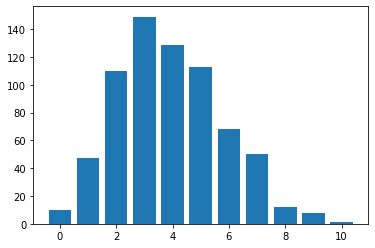

Ratio of delays below 7 days (should be around 0.90)
0.8981348637015782


In [23]:
print("2nd sample: call when value is <= 50% of value at index")

call_days = []
for i in range(pop.npersons):
    if np.logical_or(alreadyreached[i], unreached_day[i]):
        call_days.append(-1)
    else:
        index_day = sampling_days[i,0]
        index_value = sampling_symptoms[i,0]
        trigger_value = index_value * 0.5
        j = index_day+1
        while(True):
            try:
                if pop.scores['symptom'][i,j] <= trigger_value:
                    call_days.append(j)
                    break;
                else:
                    j += 1
            except IndexError:
                print(i,j)
                raise(Exception)
call_days = np.array(call_days)

has_reached_sampling_days = sampling_days[:,1] < NDAYS
has_reached_call_days = call_days > -1
has_only_one_true = np.logical_xor(has_reached_sampling_days, has_reached_call_days)
print(np.all(~has_only_one_true), f"({has_reached_call_days.sum()} / {pop.npersons} satisfy)")


reached_sampling_days = sampling_days[has_reached_sampling_days,1]
reached_call_days = call_days[has_reached_call_days]
delays = reached_sampling_days - reached_call_days

print("Plot of delays")
unique, counts = np.unique(delays, return_counts=True)
plt.bar(unique, counts)
plt.show()


print("Ratio of delays below 7 days (should be around 0.90)")
cumm = 0
tot = 0
for uni, cou in zip(unique, counts):
    if uni < 7: cumm += cou
    tot += cou
print(cumm / tot)

# Third Sample

## (given second is valid)

In [24]:
print("3nd sample (given 2nd is valid): already_reached iff sample2val <= 2")

is_prev_reached = sampling_days[:,1] < NDAYS

alreadyreached = sampling_days[is_prev_reached,2] == _ALREADYREACHED
prev_was_small = sampling_symptoms[is_prev_reached,1] <= 2
only_one_true = np.logical_xor(alreadyreached, prev_was_small)
print(np.all(~only_one_true), f"({alreadyreached.sum()} / {pop.npersons} satisfy)")

3nd sample (given 2nd is valid): already_reached iff sample2val <= 2
True (359 / 811 satisfy)


In [25]:
print("3nd sample (given 2nd is valid): unreached iff none from day of 2nd sample to end are <= 2")

is_prev_reached = sampling_days[:,1] < NDAYS

unreached_value = []
for i in range(pop.npersons):
    index_day = sampling_days[i,1]
    trigger_value = 2
    curr_and_future_values = pop.scores['symptom'][i,index_day:]
    unreached_value.append(is_prev_reached[i] and (np.min(curr_and_future_values) > trigger_value))

unreached_day = sampling_days[is_prev_reached,2] == _UNREACHED_MAGNITUDE
unreached_value = np.array(unreached_value)[is_prev_reached]
only_one_true = np.logical_xor(unreached_day, unreached_value)
print(np.all(~only_one_true), f"({unreached_day.sum()} / {pop.npersons} satisfy)")

3nd sample (given 2nd is valid): unreached iff none from day of 2nd sample to end are <= 2
True (26 / 811 satisfy)


3nd sample (given 2nd is valid): call when value is <= 2
True (308 / 811 satisfy)
Plot of delays


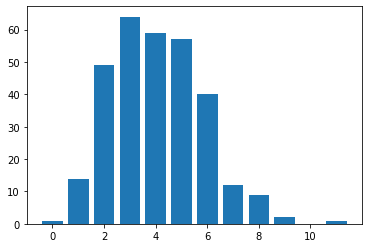

Ratio of delays below 7 days (should be around 0.90)
0.922077922077922


In [26]:
print("3nd sample (given 2nd is valid): call when value is <= 2")

is_prev_reached = sampling_days[:,1] < NDAYS

call_days = []
for i in range(pop.npersons):
    if sampling_days[i,2] >= NDAYS or not is_prev_reached[i]:
        call_days.append(-1)
    else:
        index_day = sampling_days[i,1]
        trigger_value = 2
        j = index_day+1
        while(True):
            try:
                if pop.scores['symptom'][i,j] <= trigger_value:
                    call_days.append(j)
                    break;
                else:
                    j += 1
            except IndexError:
                print(i,j)
                raise(Exception)
call_days = np.array(call_days)

has_reached_sampling_days = sampling_days[is_prev_reached,2] < NDAYS
has_reached_call_days = call_days[is_prev_reached] > -1
has_only_one_true = np.logical_xor(has_reached_sampling_days, has_reached_call_days)
print(np.all(~has_only_one_true), f"({has_reached_call_days.sum()} / {pop.npersons} satisfy)")


reached_sampling_days = sampling_days[is_prev_reached][has_reached_sampling_days,2]
reached_call_days = call_days[is_prev_reached][has_reached_call_days]
delays = reached_sampling_days - reached_call_days

print("Plot of delays")
unique, counts = np.unique(delays, return_counts=True)
plt.bar(unique, counts)
plt.show()


print("Ratio of delays below 7 days (should be around 0.90)")
cumm = 0
tot = 0
for uni, cou in zip(unique, counts):
    if uni < 7: cumm += cou
    tot += cou
print(cumm / tot)

## (given second is already_reached)

In [27]:
print("3nd sample (given 2nd is already_reached): always already_reached because first sample has value 0")

is_prev_alreadyreached = sampling_days[:,1] == _ALREADYREACHED

alreadyreached = sampling_days[is_prev_alreadyreached,2] == _ALREADYREACHED
print(np.all(alreadyreached), f"({alreadyreached.sum()} / {pop.npersons} satisfy)")

3nd sample (given 2nd is already_reached): always already_reached because first sample has value 0
True (98 / 811 satisfy)


## (given second is unreached)

In [28]:
print("3nd sample (given 2nd is unreached): already_reached iff 1st sample val <= 2")

is_prev_unreached = sampling_days[:,1] == _UNREACHED_SMILE

alreadyreached = sampling_days[is_prev_unreached,2] == _ALREADYREACHED
prev_was_small = sampling_symptoms[is_prev_unreached,0] <= 2
only_one_true = np.logical_xor(alreadyreached, prev_was_small)
print(np.all(~only_one_true), f"({alreadyreached.sum()} / {pop.npersons} satisfy)")

warn("None!")

3nd sample (given 2nd is unreached): already_reached iff 1st sample val <= 2
False (2 / 811 satisfy)


:: UserWarning: None!


In [29]:
print(_UNREACHED_SMILE, _UNREACHED_MAGNITUDE, _ALREADYREACHED)
print(sampling_days[-2:])
print(pop.scores['symptom'][-2:])

65537 65538 65540
[[   17 65537 65540]
 [   12 65537 65540]]
[[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.

In [30]:
np.random.set_state(state)

methodologies[0].sample(poster_filtered_poplists[0, 0])
methodologies[1].sample(poster_filtered_poplists[0, 0])
methodologies[0].sample(worddoc_filtered_poplists[0, 0])

pop = worddoc_filtered_poplists[0,0][0]
pop.sampling_summary = {'nsamplers':3, 'limit':[], 'if_reached':[]}

In [31]:
pop.scores['symptom'][-2] = np.array([0.8]*160)
pop.scores['symptom'][-1] = np.array([3.0]*80 + [2.0]*80)

In [32]:
sampling_days_2 = np.zeros((pop.npersons, 3), dtype=int)

sampler1.sample(pop, 0, sampling_days_2)
sampler2.sample(pop, 1, sampling_days_2)

print(sampling_days_2[-2:])

[[   17 65537     0]
 [   12 65537     0]]


In [33]:
self = sampler3
population = pop
order = 2
sampling_days_2 = sampling_days_2

smilescores = population.scores[self.scorename] #scores which the method value refers to
smilescore_lowerbound = get_MIN(self.scorename)

# Compute the days where the milestones are triggered
comparison_array = (smilescores <= self.value) if self.triggered_by_equal else (smilescores < self.value)
# Compute the days where the milestones are triggered consecutively
if self.min_triggered == 1:
    pass #don't change comparison_array
elif self.min_triggered > 1:
    triggered_in_a_row = np.ones_like(comparison_array[:,self.min_triggered-1:]) #initial
    for start in range(self.min_triggered):
        end = start + 1-self.min_triggered
        if end == 0: end = None
        triggered_in_a_row = triggered_in_a_row * comparison_array[:,start:end] # accumulate
    comparison_array[:,self.min_triggered-1:] = triggered_in_a_row #we only checked when enough days have passed
    comparison_array[:,:self.min_triggered-1] = False #the rest can't have had enough days in a row

In [34]:
temp = []

In [35]:
#only check on or after previous (valid) sample day by
#setting the comparison values from days 0 to prev sample day (excluding end) to False
if order > 0:
    for i in range(population.npersons):
        #for getting valid prev day
        for prev_order in range(order-1, 0-1, -1):
            prev_sample_day = sampling_days_2[i, prev_order]
            if prev_sample_day < NDAYS: break
        #for setting days until then as don't consider
        temp.append(prev_sample_day)
        comparison_array[i,:prev_sample_day] = False
#if it is True on the same day as the previous sample day, the finish_sampling will consider it already_reached

In [36]:
#the day at which the milestone is reached for each person
sampling_days_2_temp = np.argmax(comparison_array, axis=1) 
#the day at which the milestone is reached for each person, inc. 0 for 'never reached'
sampling_days_2[:,order] = sampling_days_2_temp 
#record of which persons reached the milestones
persons_reached_milestone = np.take_along_axis(comparison_array, 
                                               helper.to_vertical(sampling_days_2_temp), 
                                               axis=1)
#give invalid day to those who didn't reach
sampling_days_2[~persons_reached_milestone.flatten(), order] = _UNREACHED_MAGNITUDE
if not np.all(persons_reached_milestone): 
    warn(f"There are {(~persons_reached_milestone.flatten()).sum()} who didn't reach their milestone")

In [41]:
sampling_days_2[-2:]

array([[   17, 65537,    17],
       [   12, 65537,    80]])

In [49]:
#checks if new calling day is on the same day as the prev sample or before
#TraditionalSampler is allowed to have new calling day on the same day as prev (but not before)
if not isinstance(self, TraditionalSampler): #TODO make this check a parameter set in class definition
    already_reached = (sampling_days_2[:,order] <= sampling_days_2[:,order-1])
else:
    already_reached = (sampling_days_2[:,order] < sampling_days_2[:,order-1])

if np.any(already_reached): 
    print(f"There are {already_reached.sum()} who had already reached their milestone")

There are 459 who had already reached their milestone


In [ ]:
if self.if_reached == 'same':
    #fast forwards new sample to previous sample
    sampling_days_2[:,order] = np.where(already_reached, sampling_days_2[:,order-1], sampling_days_2[:,order])
if self.if_reached == 'NaN':
    #will be masked with fill_value = NaN
    sampling_days_2[:,order] = np.where(already_reached, _ALREADYREACHED, sampling_days_2[:,order]) 
if self.if_reached == 'raise':
    if np.any(already_reached): 
        raise ValueError("Patient was already here when he arrived for his prev sample")
#remember how many triggered if_reached
population.sampling_summary['if_reached'].append((np.sum(already_reached), self.if_reached))

In [ ]:
raise Exception

In [39]:
#add delay
persons_valid = sampling_days_2[:,order] < NDAYS
npersons_valid = persons_valid.sum()
if isinstance(self.delay, int):
    sampling_days_2[persons_valid,order] += self.delay
elif callable(self.delay):
    sampling_days_2[persons_valid,order] += self.delay((npersons_valid,))

In [40]:
sampling_days_2[-2:]

array([[   17, 65537, 65540],
       [   12, 65537, 65540]])

In [42]:
#limit #TODO ask if should be done before delay
limitval, limitbehaviour = self.limit #unpack
if isinstance(limitval, int):
    limitvals = limitval #numpy will broadcast to the right shape
elif isinstance(limitval, tuple):
    ref_index, limitvalfunc = limitval #unpack
    prev_sampling_days_2 = sampling_days_2[:,:order]
    limitvals = limitvalfunc(prev_sampling_days_2[:,ref_index])
#check where reached or exceeded limit
reached_limit = sampling_days_2[:,order] > limitvals
reached_limit = np.logical_and(reached_limit, persons_valid) #ignore those already_sampled
#act on limit
if limitbehaviour == 'raise':
    if np.any(reached_limit):
        raise IndexError("Reached limit") #TODO better error message
if limitbehaviour == 'clip':
    sampling_days_2[:,order] = np.where(reached_limit, limitvals, sampling_days_2[:,order])
if limitbehaviour == 'NaN':
    #will be masked with fill_value = NaN
    sampling_days_2[:,order] = np.where(reached_limit, _LIMITREACHED, sampling_days_2[:,order])
#TODO add ('replace', replaceval) as a limitbehaviour option (where 'clip would be a special case')
#remember how many triggered limit
population.sampling_summary['limit'].append((np.sum(reached_limit), limitbehaviour))

In [43]:
sampling_days_2[-2:]

array([[   17, 65537, 65540],
       [   12, 65537, 65540]])

In [32]:
raise Exception

Exception: 

In [27]:
print("3nd sample (given 2nd is unreached): unreached iff none from day of 1st sample to end are <= 2")

is_prev_unreached = sampling_days[:,1] == _UNREACHED_SMILE

unreached_value = []
for i in range(pop.npersons):
    try:
        index_day = sampling_days[i,0]
        trigger_value = 2
        curr_and_future_values = pop.scores['symptom'][i,index_day:]
        unreached_value.append(is_prev_unreached[i] and (np.min(curr_and_future_values) > trigger_value))
    except Exception as e:
        print(i)
        raise(e)

unreached_day = sampling_days[is_prev_unreached,2] == _UNREACHED_MAGNITUDE
unreached_value = np.array(unreached_value)[is_prev_unreached]
only_one_true = np.logical_xor(unreached_day, unreached_value)
print(np.all(~only_one_true), f"({unreached_day.sum()} / {pop.npersons} satisfy)")

3nd sample (given 2nd is unreached): unreached iff none from day of 1st sample to end are <= 2
False (16 / 811 satisfy)


3nd sample (given 2nd is unreached): call when value is <= 2
True (0 / 811 satisfy)
Plot of delays


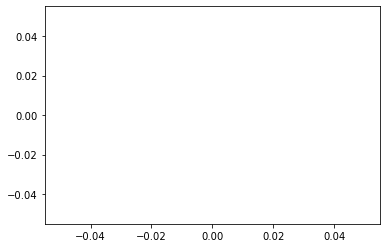

Ratio of delays below 7 days (should be around 0.90)


ZeroDivisionError: division by zero

In [28]:
print("3nd sample (given 2nd is unreached): call when value is <= 2")

is_prev_unreached = sampling_days[:,1] == _UNREACHED_SMILE

call_days = []
for i in range(pop.npersons):
    if sampling_days[i,2] >= NDAYS or not is_prev_unreached[i]:
        call_days.append(-1)
    else:
        index_day = sampling_days[i,0]
        trigger_value = 2
        j = index_day+1
        while(True):
            try:
                if pop.scores['symptom'][i,j] <= trigger_value:
                    call_days.append(j)
                    break;
                else:
                    j += 1
            except IndexError:
                print(i,j)
                raise(Exception)
call_days = np.array(call_days)

has_reached_sampling_days = sampling_days[is_prev_unreached,2] < NDAYS
has_reached_call_days = call_days[is_prev_unreached] > -1
has_only_one_true = np.logical_xor(has_reached_sampling_days, has_reached_call_days)
print(np.all(~has_only_one_true), f"({has_reached_call_days.sum()} / {pop.npersons} satisfy)")

warn("None!")


reached_sampling_days = sampling_days[is_prev_unreached][has_reached_sampling_days,2]
reached_call_days = call_days[is_prev_unreached][has_reached_call_days]
delays = reached_sampling_days - reached_call_days

print("Plot of delays")
unique, counts = np.unique(delays, return_counts=True)
plt.bar(unique, counts)
plt.show()


print("Ratio of delays below 7 days (should be around 0.90)")
cumm = 0
tot = 0
for uni, cou in zip(unique, counts):
    if uni < 7: cumm += cou
    tot += cou
print(cumm / tot)

In [43]:
arr = np.arange(15).reshape(3,5)
print(arr)
brr = np.array([[1], [3], [5]])
print(brr)
np.take_along_axis(arr, brr, axis=1)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
[[1]
 [3]
 [5]]


IndexError: index 5 is out of bounds for axis 1 with size 5